In [ ]:
import torch
import numpy as np
import random

# Set random seeds to ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [ ]:
import os

# Path to the downloaded dataset
dataset_path = '/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1'

# List files and directories in the path
os.listdir(dataset_path)


['images', 'README.txt']

In [ ]:
# List the subfolders in the dataset directory
image_folder_path = os.path.join(dataset_path, 'images')

# List the contents of the 'images' folder
os.listdir(image_folder_path)


['images']

In [ ]:
# Assuming the nested folder is called 'your_subfolder_name'
nested_image_folder_path = os.path.join(image_folder_path, 'images')

# List the contents of the nested folder
print(len(os.listdir(nested_image_folder_path)))
print(os.listdir(nested_image_folder_path))

30
['cardboard_boxes', 'coffee_grounds', 'shoes', 'clothing', 'aerosol_cans', 'office_paper', 'food_waste', 'plastic_straws', 'eggshells', 'plastic_soda_bottles', 'disposable_plastic_cutlery', 'newspaper', 'styrofoam_cups', 'plastic_cup_lids', 'glass_beverage_bottles', 'aluminum_soda_cans', 'steel_food_cans', 'tea_bags', 'plastic_water_bottles', 'plastic_shopping_bags', 'paper_cups', 'styrofoam_food_containers', 'magazines', 'aluminum_food_cans', 'plastic_food_containers', 'cardboard_packaging', 'plastic_detergent_bottles', 'glass_food_jars', 'plastic_trash_bags', 'glass_cosmetic_containers']


In [ ]:
#Imports
import torchvision.transforms.functional
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as v2

class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                # Split the data into train, val, and test
                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "label": label
        }

# Define Image Transformation Pipeline
train_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    lambda x: x.to(torch.float32),  # Convert tensor to float32
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

val_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    lambda x: x.to(torch.float32),  # Convert tensor to float32
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    lambda x: x.to(torch.float32),  # Convert tensor to float32
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Prepare datasets and dataloaders
data_transforms = {
    "train": train_pil_transform,
    "val": val_pil_transform,
    "test": test_pil_transform
}

# Assuming dataset is located at the following path
dataset_root = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images"

train_dataset = WasteDataset(dataset_root, "train", data_transforms["train"])
val_dataset = WasteDataset(dataset_root, "val", data_transforms["val"])
test_dataset = WasteDataset(dataset_root, "test", data_transforms["test"])

# Create data loaders
batch_size = 16
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)


# Organize data loaders
data_loaders = {
    "train": train_data_loader,
    "val": val_data_loader,
    "test": test_data_loader
}

# Store class names (labels)
class_names = train_dataset.classes
dataset_sizes = {x: len(data_loaders[x].dataset) for x in ['train', 'val', 'test']}

# Print summary
print(f"Training Dataset Size: {dataset_sizes['train']}")
print(f"Validation Dataset Size: {dataset_sizes['val']}")
print(f"Test Dataset Size: {dataset_sizes['test']}")


Training Dataset Size: 9000
Validation Dataset Size: 3000
Test Dataset Size: 3000


In [ ]:
# Apply the transformation for each dataset
train_dataset = WasteDataset(dataset_root, "train", train_pil_transform)
val_dataset = WasteDataset(dataset_root, "val", val_pil_transform)
test_dataset = WasteDataset(dataset_root, "test", test_pil_transform)

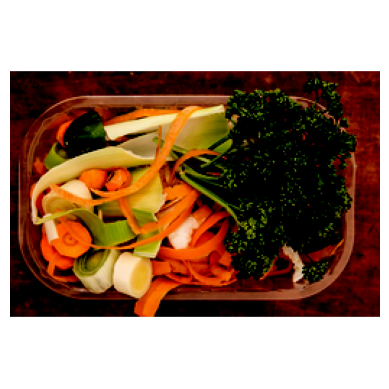

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as v2
from PIL import Image
import os

# Function to visualize image directly after transformation (without unnormalizing)
def imshow(tensor, title=None):
    """Display the tensor directly without unnormalizing"""

    # Convert tensor to numpy (H x W x C format for display)
    image = tensor.numpy().transpose((1, 2, 0))  # Convert to HWC format

    # Clamp values to [0, 1] range to ensure valid display (important for negative values in normalized tensors)
    image = image.clip(0, 1)

    # Plot the image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Define image transformations
train_transform = v2.Compose([
    v2.Resize((224, 224)),                # Resize the image
    v2.ToTensor(),                        # Convert image to tensor and scale values to [0, 1]
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
])

# Load and preprocess images
def load_and_transform_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = train_transform(image)
    return image_tensor

# Example usage
image_path = "Image_6.png"  # Provide a valid path to an image in your dataset
transformed_image = load_and_transform_image(image_path)

# Visualize the image after transformation (without reversing normalization)
imshow(transformed_image)


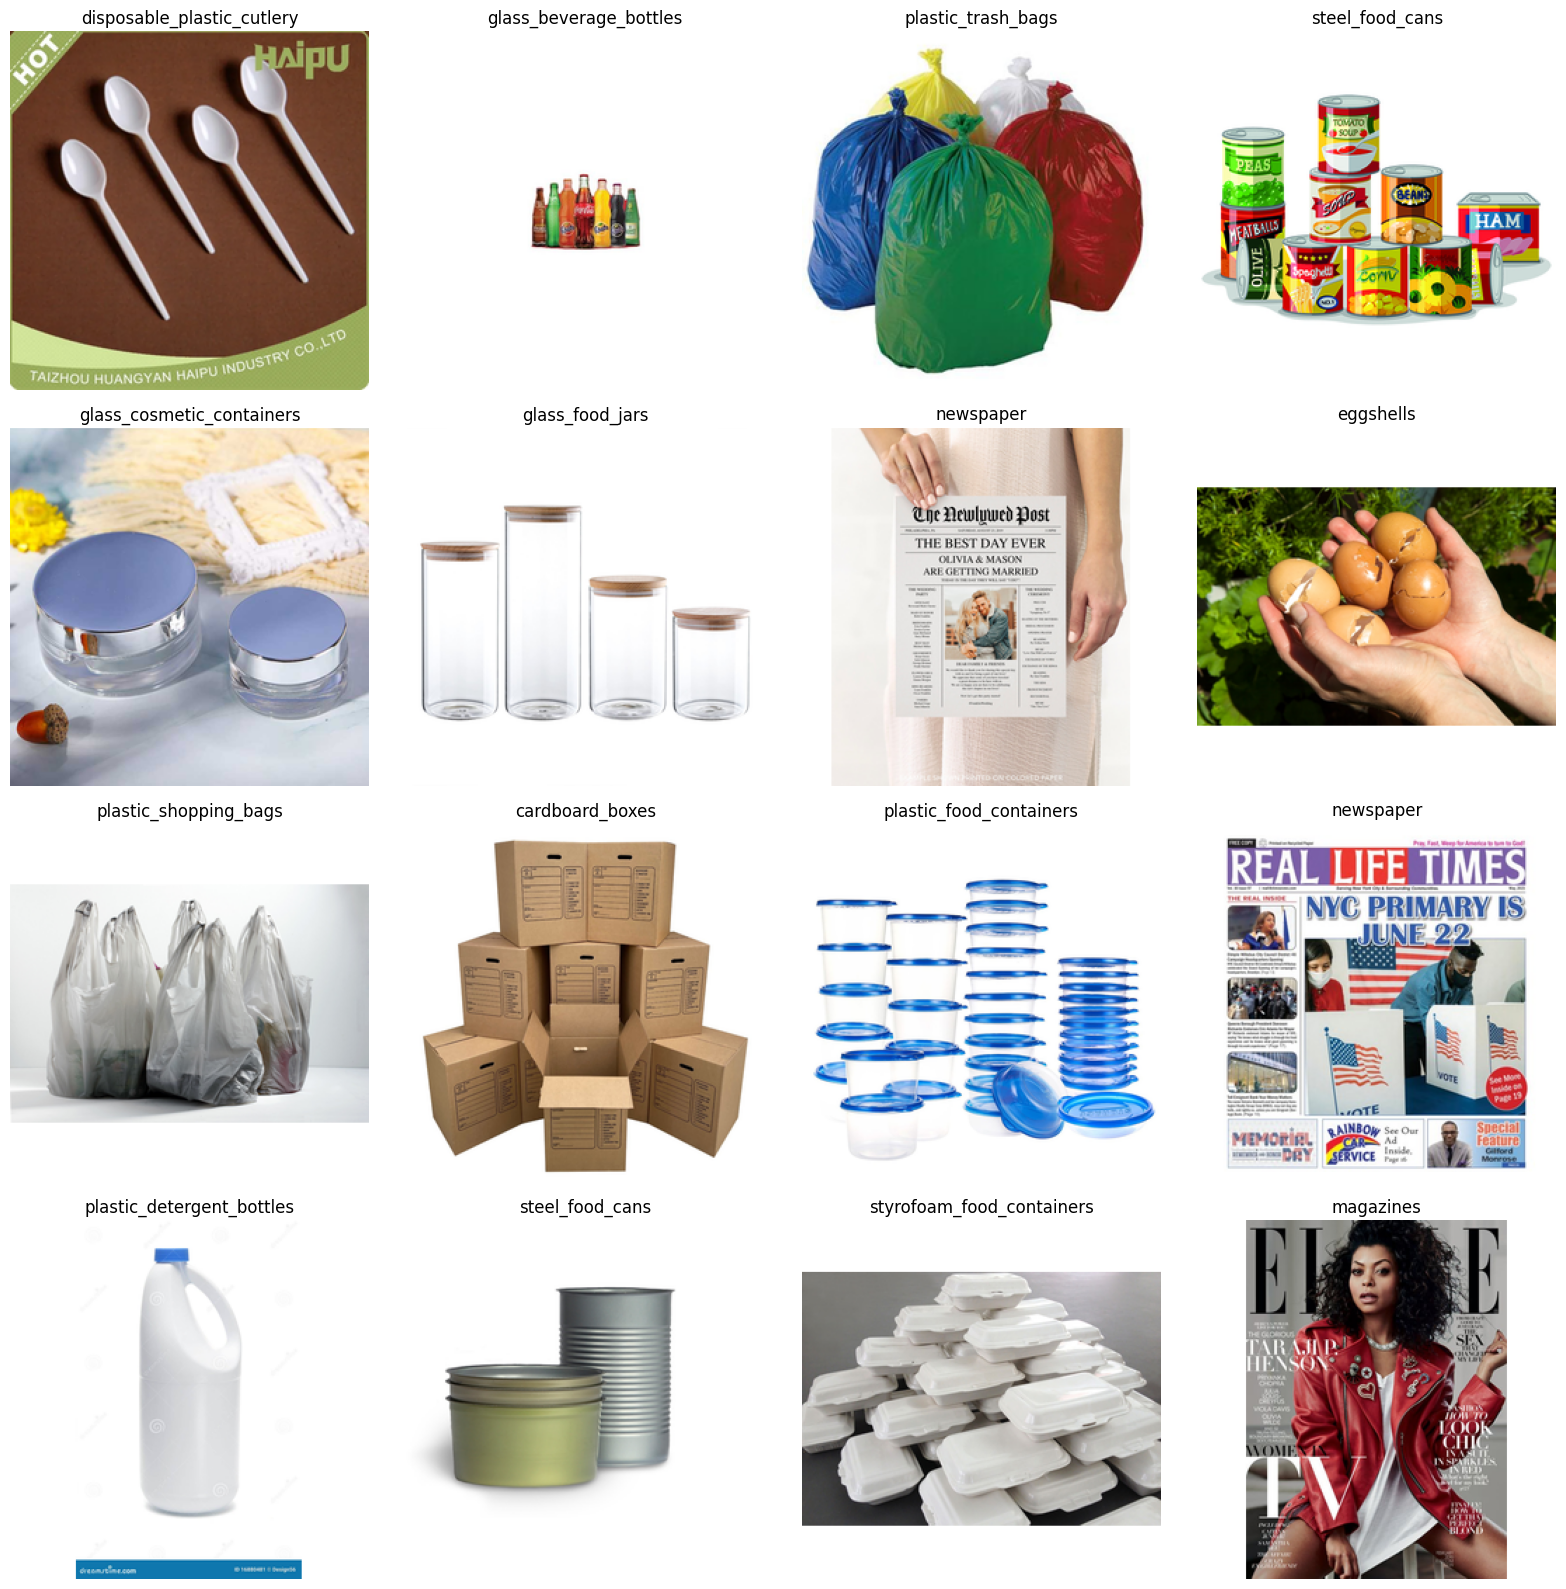

In [ ]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(batch_size, batch_size))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # loop over the batch size
    for i in range(0, batch_size):
        # create a subplot with 4x8
        ax = plt.subplot(4, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch["image"][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = std * image + mean
        image = image.astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch["label"][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

#visualize train data
train_batch = next(iter(data_loaders["train"]))
visualize_batch(train_batch,class_names,"train")

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import efficientnet_b0

class EfficientNetWasteClassificationModel(nn.Module):
    def __init__(self, num_classes=30):
        super(EfficientNetWasteClassificationModel, self).__init__()

        # Load EfficientNet pre-trained weights
        self.efficientnet = efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Remove the final classification layer (fc) from EfficientNet
        self.features = self.efficientnet.features

        # Add a custom classifier for your specific number of classes (30 in this case)
        self.fc1 = nn.Linear(1280, 512)  # 1280 is the output features of efficientnet_b0
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 'num_classes' classes

        # Dropout layer to prevent overfitting
        self.dr = nn.Dropout(p=0.5)

    def forward(self, x):
        # Extract features using EfficientNet backbone
        x = self.features(x)

        # Global average pooling (to reduce spatial dimensions to 1x1)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.flatten(start_dim=1)

        # Pass through the classifier layers
        x = F.relu(self.fc1(x))
        x = self.dr(x)
        x = self.fc2(x)

        return x

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetWasteClassificationModel(num_classes=30).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler for learning rate decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and validation function with metric storage
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data['image'].to(device), data['label'].to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step for learning rate scheduler in training phase
            if phase == 'train':
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Store the loss and accuracy for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 25
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, data_loaders, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/25
----------
Train Loss: 1.6218 Acc: 0.5384
Val Loss: 0.8174 Acc: 0.7483
Epoch 2/25
----------
Train Loss: 1.0184 Acc: 0.6928
Val Loss: 0.6728 Acc: 0.7883
Epoch 3/25
----------
Train Loss: 0.8004 Acc: 0.7516
Val Loss: 0.6787 Acc: 0.8003
Epoch 4/25
----------
Train Loss: 0.6769 Acc: 0.7842
Val Loss: 0.4987 Acc: 0.8480
Epoch 5/25
----------
Train Loss: 0.5819 Acc: 0.8089
Val Loss: 0.5743 Acc: 0.8277
Epoch 6/25
----------
Train Loss: 0.5392 Acc: 0.8213
Val Loss: 0.5645 Acc: 0.8357
Epoch 7/25
----------
Train Loss: 0.4795 Acc: 0.8423
Val Loss: 0.4008 Acc: 0.8757
Epoch 8/25
----------
Train Loss: 0.2508 Acc: 0.9088
Val Loss: 0.2935 Acc: 0.9130
Epoch 9/25
----------
Train Loss: 0.1720 Acc: 0.9331
Val Loss: 0.2925 Acc: 0.9177
Epoch 10/25
----------
Train Loss: 0.1484 Acc: 0.9452
Val Loss: 0.2794 Acc: 0.9213
Epoch 11/25
----------
Train Loss: 0.1269 Acc: 0.9500
Val Loss: 0.2898 Acc: 0.9213
Epoch 12/25
----------
Train Loss: 0.1093 Acc: 0.9572
Val Loss: 0.2951 Acc: 0.9227
Epoch 13/25
-

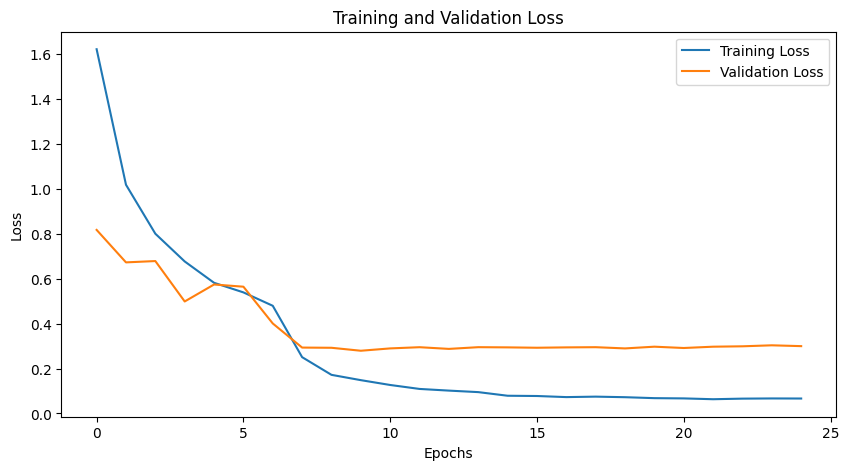

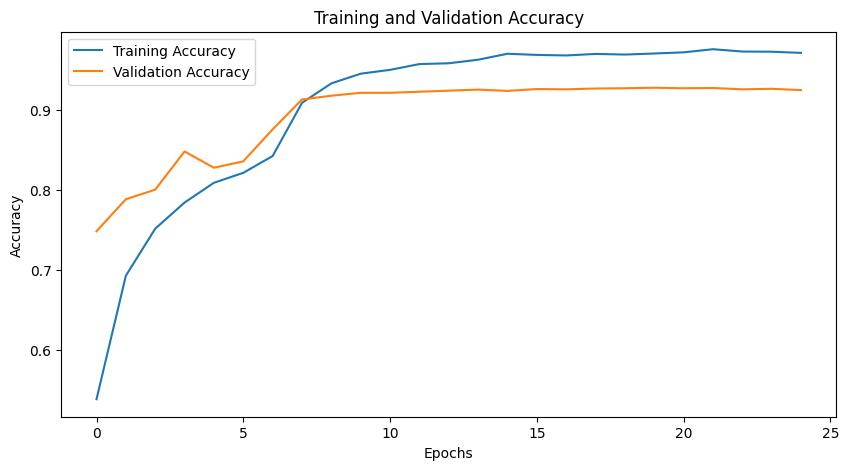

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode

test_running_loss = 0.0
test_running_corrects = 0

# No need to track gradients for testing, so use torch.no_grad()
with torch.no_grad():
    for data in data_loaders['test']:
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)  # Corrected here

        # Update statistics
        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)

# Calculate overall test loss and accuracy
test_loss = test_running_loss / dataset_sizes['test']
test_accuracy = test_running_corrects.double() / dataset_sizes['test']

print(f"Test Loss: {test_loss:.4f} Acc: {test_accuracy:.4f}")


Test Loss: 0.2661 Acc: 0.9357


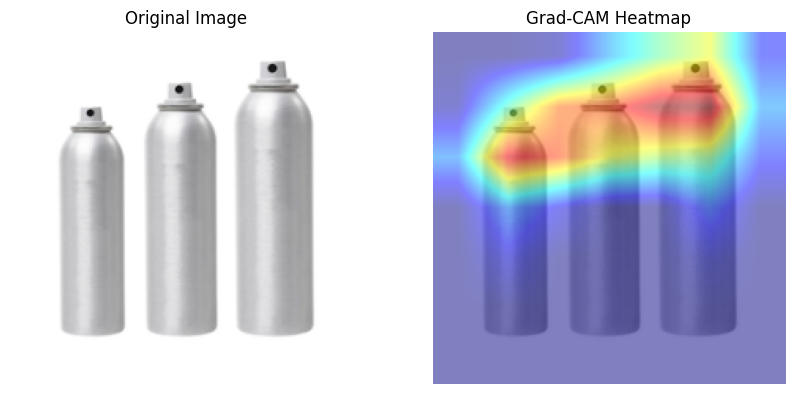

In [ ]:
#correct one
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import efficientnet_b0
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the EfficientNet model for waste classification
class EfficientNetWasteClassificationModel(nn.Module):
    def __init__(self, num_classes=30):
        super(EfficientNetWasteClassificationModel, self).__init__()

        # Load EfficientNet pre-trained weights
        self.efficientnet = efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Remove the final classification layer (fc) from EfficientNet
        self.features = self.efficientnet.features

        # Add a custom classifier for your specific number of classes (30 in this case)
        self.fc1 = nn.Linear(1280, 512)  # 1280 is the output features of efficientnet_b0
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 'num_classes' classes

        # Dropout layer to prevent overfitting
        self.dr = nn.Dropout(p=0.5)

    def forward(self, x):
        # Extract features using EfficientNet backbone
        x = self.features(x)

        # Global average pooling (to reduce spatial dimensions to 1x1)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.flatten(start_dim=1)

        # Pass through the classifier layers
        x = F.relu(self.fc1(x))
        x = self.dr(x)
        x = self.fc2(x)

        return x

# Grad-CAM class to handle the backward pass and heatmap generation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for storing activations
        self.hook = self.target_layer.register_forward_hook(self.save_activation)
        self.grad_hook = self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_image)

        # Get the predicted class
        predicted_class = torch.argmax(output, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        output[0, predicted_class].backward(retain_graph=True)

        # Get the gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Global average pooling on gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        grad_cam_map = torch.sum(weights * activations, dim=1, keepdim=True)

        # Apply ReLU to the grad_cam_map
        grad_cam_map = F.relu(grad_cam_map)

        # Normalize the Grad-CAM heatmap
        grad_cam_map = grad_cam_map.squeeze().cpu().detach().numpy()
        grad_cam_map = np.maximum(grad_cam_map, 0)
        grad_cam_map = grad_cam_map / grad_cam_map.max()

        return grad_cam_map, predicted_class

# Set the device (ensure both model and image are on the same device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = EfficientNetWasteClassificationModel(num_classes=30)
model = model.to(device)

# Set the model to evaluation mode (ensure dropout layers are disabled during inference)
model.eval()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load a sample image and preprocess it
image = cv2.imread('Image_4.png')
image_resized = cv2.resize(image, (224, 224))  # Resize to EfficientNet's input size

# Transform the image
image_transformed = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(image_resized).unsqueeze(0)

# Move image to the correct device
image_transformed = image_transformed.to(device)

# Ensure that the image requires gradients for Grad-CAM
image_transformed.requires_grad_()

# Create Grad-CAM object
target_layer = model.features[-1]  # Access the last convolutional layer
grad_cam = GradCAM(model, target_layer)

# Generate the Grad-CAM heatmap
heatmap, predicted_class = grad_cam(image_transformed)

# Overlay the heatmap on the original image
heatmap_resized = cv2.resize(heatmap, (image_resized.shape[1], image_resized.shape[0]))
overlayed_image = np.uint8(255 * heatmap_resized)  # Convert heatmap to an image
overlayed_image = cv2.applyColorMap(overlayed_image, cv2.COLORMAP_JET)
overlayed_image = cv2.addWeighted(overlayed_image, 0.5, image_resized, 0.5, 0)

# Display the original and overlayed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.show()


In [ ]:
# Saving the model
torch.save(model.state_dict(), "efficientnet_waste_model.pth")

In [ ]:
!pip install streamlit cloudflared

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.6 MB/s eta 0:00:00
  Created wheel for cloudflared: filename=cloudflared-1.0.0.2-py3-none-any.whl size=2984 sha256=7c5b63bdebe60fb05e302a2c52e95149dea6e7e5258afa737c8d95d1c4c4baed
  Stored in directory: /root/.cache/pip/wheels/6b/00/71/ea5fa0bfe899be948e296b3f357de632b8c30b6546c1e50100
Successfully built cloudflared


In [ ]:
%%writefile app.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import efficientnet_b0
import streamlit as st
from PIL import Image
import io

# Define class names for your classes

class_names = [
    'clothing', 'styrofoam food containers', 'styrofoam cups', 'plastic water bottles', 'glass beverage bottles',
    'aluminum soda cans', 'glass cosmetic containers', 'paper cups', 'plastic cup lids', 'plastic straws',
    'aerosol cans', 'plastic food containers', 'newspaper', 'cardboard boxes', 'tea bags', 'plastic shopping bags', 'office paper',
    'aluminum food cans',  'plastic trash bags','plastic soda bottles','food waste' , 'eggshells', 'cardboard packaging', 'disposable plastic cutlery',
    'glass food jars', 'shoes', 'coffee grounds', 'magazines', 'steel food cans', 'plastic detergent bottles']


# Define the EfficientNet model for waste classification
class EfficientNetWasteClassificationModel(nn.Module):
    def __init__(self, num_classes=30):
        super(EfficientNetWasteClassificationModel, self).__init__()
        self.efficientnet = efficientnet_b0(weights="IMAGENET1K_V1")
        self.features = self.efficientnet.features
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dr = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dr(x)
        x = self.fc2(x)
        return x

# Initialize model, load weights
model = EfficientNetWasteClassificationModel(num_classes=30)
model.load_state_dict(torch.load("/content/efficientnet_waste_model.pth", map_location=torch.device('cpu')))
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Streamlit interface
st.title("EfficientNet Waste Classification")
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")

    # Display the image with a fixed width (e.g., 300px)
    st.image(image, caption='Uploaded Image.', use_container_width=False, width=200)  # Adjust width as needed
    st.write("Classifying...")

    # Preprocessing and model inference
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    predicted_class_name = class_names[predicted_class.item()]
    st.write(f"Predicted Class: {predicted_class_name}")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx cloudflared tunnel --url http://localhost:8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.32.132.100:8501

2024-11-12T04:47:11Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2024-11-12T04:47:11Z INF Requesting new quick Tunnel on trycloudflare.com...
2024-11-12T04:47:15Z INF +--------------------------------------------------------------------------------------------+
2024-11-12T04:47:15Z INF 